In [2]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

import pickle

# check pytorch version
import torch    
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

%load_ext autoreload
%autoreload 2
from functions import *
from torch_model import *

## Create graph data

In [46]:
data_path = "D:\\PINN\\data"
with open(data_path + '/train_cnn_2019_2022_v2.pkl', 'rb') as file:
    xx, yy, days, months, years, cnn_input, cnn_output = pickle.load(file)

xx = xx[41:, :-41]
yy = yy[41:, :-41]


cnn_input = np.transpose(cnn_input, (0, 3, 1, 2))[:, :, 41:, :-41].astype(np.double)
cnn_output = np.transpose(cnn_output, (0, 3, 1, 2))[:, :, 41:, :-41].astype(np.double)

n_samples, n_channels, row, col = np.shape(cnn_input)

xx_n = (xx - xx.min())/(xx.max() - xx.min())
yy_n = (yy - yy.min())/(yy.max() - yy.min())

# xx_n = np.expand_dims(np.expand_dims(xx_n, axis = 0), axis = 0)
# yy_n = np.expand_dims(np.expand_dims(yy_n, axis = 0), axis = 0)

# xx_n = np.repeat(xx_n, n_samples, axis=0)
# yy_n = np.repeat(yy_n, n_samples, axis=0)

# cnn_input = np.append(cnn_input, xx_n, axis = 1)
# cnn_input = np.append(cnn_input, yy_n, axis = 1)

# n_samples, n_channels, row, col = np.shape(cnn_input)


In [ ]:
G.add_edges_from([((x, y), (x+1, y+1)) for x in range(20) for y in range(20)] + [((x+1, y), (x, y+1)) for x in range(20) for y in range(20)] )

In [48]:
# 1-step edges
data_list = []

for i in tqdm(range(0, n_samples)):
    G = nx.grid_2d_graph(row,col)
    for x, y in G.edges:
        G[x][y]['weight'] = 1
        
    G.add_edges_from([((x, y), (x+1, y+1)) for x in range(row-1) for y in range(col-1)] + [((x+1, y), (x, y+1)) for x in range(row-1) for y in range(col-1)],
                    weight = 1.414)
    
    x = {node: torch.cat((torch.cat((torch.tensor([cnn_input[i][c][node] for c in range(0, n_channels)]), torch.tensor([xx_n[node]]))), torch.tensor([yy_n[node]])))
         for node in G.nodes()}
    y = {node: torch.tensor([cnn_output[i][c][node] for c in range(0, 3)]) for node in G.nodes()}
    nx.set_node_attributes(G, x, 'x')
    nx.set_node_attributes(G, y, 'y')
    
    data = from_networkx(G)
    filename = int(years[i]*10000 + months[i]*100 + days[i])
    torch.save(data, f'../data/Graph/Grid_graph_{filename}.pt')
    # data_list.append(data)
    
# loader = DataLoader(data_list, batch_size=32)

100%|████████████████████████████████████████████████████████████████████████████| 1093/1093 [8:07:35<00:00, 26.77s/it]


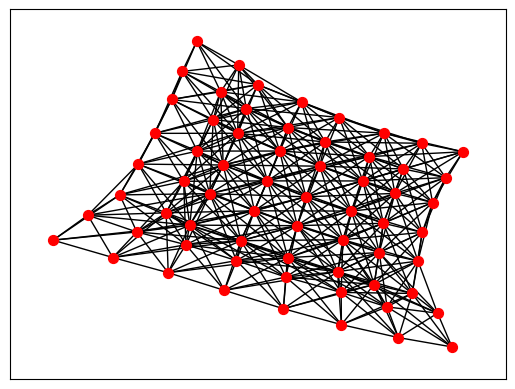

In [21]:
nx.draw_networkx(G, with_labels = False, node_size = 50, node_color = "red")

In [50]:
data_list = []

for i in tqdm(range(0, n_samples)):
    G = nx.grid_2d_graph(row,col)   
    
    for x, y in G.edges:
        G[x][y]['weight'] = 1
        
    # one-step edges
    G.add_edges_from([((x, y), (x+1, y+1)) for x in range(row-1) for y in range(col-1)] + [((x+1, y), (x, y+1)) for x in range(row-1) for y in range(col-1)],
                    weight = 0.7071)
    # two-step edges
    G.add_edges_from([((x, y), (x+2, y)) for x in range(row-2) for y in range(col-2)] + [((x, y), (x, y+2)) for x in range(row-2) for y in range(col-2)],
                    weight = 1/2)
    G.add_edges_from([((x, y), (x+2, y+1)) for x in range(row-2) for y in range(col-2)] + [((x, y), (x+1, y+2)) for x in range(row-2) for y in range(col-2)],
                    weight = 0.4472)
    G.add_edges_from([((x, y), (x+2, y+2)) for x in range(row-2) for y in range(col-2)] + [((x+2, y+2), (x, y+2)) for x in range(row-2) for y in range(col-2)],
                    weight = 0.3536)
    G.add_edges_from([((x+1, y), (x, y+2)) for x in range(row-2) for y in range(col-2)] + [((x+2, y), (x, y+1)) for x in range(row-2) for y in range(col-2)],
                    weight = 0.4472)
    
    x = {node: torch.cat((torch.cat((torch.tensor([cnn_input[i][c][node] for c in range(0, n_channels)]), torch.tensor([xx_n[node]]))), torch.tensor([yy_n[node]])))
         for node in G.nodes()}
    y = {node: torch.tensor([cnn_output[i][c][node] for c in range(0, 3)]) for node in G.nodes()}
    nx.set_node_attributes(G, x, 'x')
    nx.set_node_attributes(G, y, 'y')
    
    data = from_networkx(G)
    filename = int(years[i]*10000 + months[i]*100 + days[i])
    torch.save(data, data_path + f'/Graph/Grid_graph_w2_{filename}.pt')
    
    del data, G
    # data_list.append(data)
    
# loader = DataLoader(data_list, batch_size=32)

100%|█████████████████████████████████████████████████████████████████████████| 1457/1457 [22:35:04<00:00, 55.80s/it]


In [19]:
row = 7
col = 7

G = nx.grid_2d_graph(row,col)   
    
for x, y in G.edges:
    G[x][y]['weight'] = 1

# one-step edges
G.add_edges_from([((x, y), (x+1, y+1)) for x in range(row-1) for y in range(col-1)] + [((x+1, y), (x, y+1)) for x in range(row-1) for y in range(col-1)],
                weight = 0.7071)
# two-step edges
G.add_edges_from([((x, y), (x+2, y)) for x in range(row-2) for y in range(col-2)] + [((x, y), (x, y+2)) for x in range(row-2) for y in range(col-2)],
                weight = 1/2)
G.add_edges_from([((x, y), (x+2, y+1)) for x in range(row-2) for y in range(col-2)] + [((x, y), (x+1, y+2)) for x in range(row-2) for y in range(col-2)],
                weight = 0.4472)
G.add_edges_from([((x, y), (x+2, y+2)) for x in range(row-2) for y in range(col-2)] + [((x+2, y+2), (x, y+2)) for x in range(row-2) for y in range(col-2)],
                weight = 0.3536)
G.add_edges_from([((x+1, y), (x, y+2)) for x in range(row-2) for y in range(col-2)] + [((x+2, y), (x, y+1)) for x in range(row-2) for y in range(col-2)],
                weight = 0.4472)

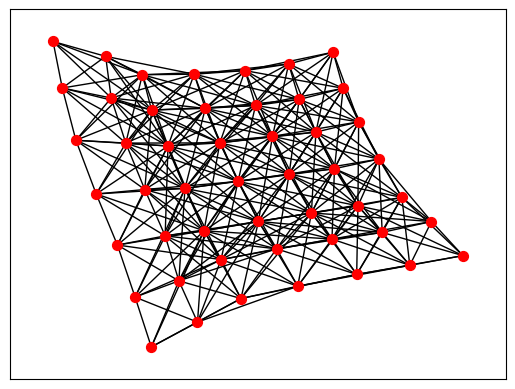

In [29]:
nx.draw_networkx(G, with_labels = False, node_size = 50, node_color = "red")

In [ ]:
torch.save(data, f'../data/Graph/Grid_graph_{2019}.pt')

In [ ]:
torch.

## Read data

In [53]:
year = 2020
data_path = "D:\\PINN\\data"

files = glob.glob(data_path + f'/Graph/Grid_graph_w2_{year}*.pt')

data_list = []
val_list = []

for f in tqdm(files):
    day = int(f[-7:-5])
    d = torch.load(f)
    if day % 4 == 2:
        val_list.append(d)
    else:
        data_list.append(d)

batch_size = 16
loader = DataLoader(data_list, batch_size=batch_size)
val_loader = DataLoader(val_list, batch_size=batch_size)

torch.save(loader, f'{data_path}/Graph/Grid_graph_{year}_train_batch_{batch_size}.pt')
torch.save(val_loader, f'{data_path}/Graph/Grid_graph_{year}_val_batch_{batch_size}.pt')

100%|██████████████████████████████████████████████████████████████████████████████| 364/364 [03:47<00:00,  1.60it/s]


In [52]:
files

['D:\\PINN\\data/Graph/Grid_graph_w2_20221230.pt']

In [54]:
loader

In [9]:
loader = torch.load(f'{data_path}/Graph/Grid_graph_{year}_train_batch_{batch_size}.pt')
val_loader = torch.load(f'{data_path}/Graph/Grid_graph_{year}_val_batch_{batch_size}.pt')

In [10]:
len(val_loader)

6

In [114]:
for f in tqdm(files[:-100]):
    d = torch.load(f)
    data_list.append(d)
    
torch.save(loader, f'{data_path}/data/Graph/Grid_graph_{2019}.pt')

# with open(data_path + f'train_gcn_{year}.pkl', 'rb') as file:
#     data_list = pickle.load(file)


loader = DataLoader(data_list, batch_size=batch_size)

val_list = []
for f in tqdm(files[-100:]):
    d = torch.load(f)
    val_list.append(d)

In [91]:
gcn_save = [xx, yy, days, months, years, data_list]

# Open a file and use dump()
with open(data_path + '/train_gcn_2019_2021.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(data_list, file)

## Train model

In [64]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels = 32):
        super().__init__()
        # torch.manual_seed(12345)
        self.lin1 = nn.Linear(8, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, 3)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x


# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels = 32):
#         super().__init__()
#         # torch.manual_seed(1234)
#         self.conv1 = GCNConv(8, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, 3)

#     def forward(self, x, edge_index):
#         h = self.conv1(x, edge_index)
#         h = F.leaky_relu(h, negative_slope=1)
#         h = self.conv2(h, edge_index)
#         h = F.leaky_relu(h, negative_slope=1)
#         h = self.conv3(h, edge_index)
#         # h = h.tanh()  # Final GNN embedding space.

#         return h


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels = 64):
        super().__init__()
        # torch.manual_seed(1234567)
        self.conv1 = GCNConv(8, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, 3)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index), negative_slope=1); #self.conv1(x)
        x = F.leaky_relu(self.conv2(x, edge_index), negative_slope=1);
        x = F.leaky_relu(self.conv3(x, edge_index), negative_slope=1);
        x = F.leaky_relu(self.conv4(x, edge_index), negative_slope=1);
        x = F.leaky_relu(self.conv5(x, edge_index), negative_slope=1);
        # x = x.relu() #x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        return x

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(8, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 3)
)


In [57]:
model = MLP()
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1443


In [58]:
total_params = sum(p.numel() for p in GCN().parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1443


In [100]:
# torch.cuda.empty_cache()
device = 'cpu' #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = GCN().to(device)
print(model)
criterion = torch.nn.L1Loss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

n_epochs = 10

with tqdm(loader, unit="batch", mininterval=0, disable=False) as bar:
    bar.set_description(f"Epoch {epoch}/{n_epochs}")
    for data in bar:
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x.to(torch.float).to(device), data.edge_index.to(device))  # Perform a single forward pass.
        loss = criterion(out.to(device), data.y.to(device))  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.  
        bar.set_postfix(loss=float(loss))

GCN(
  (conv1): GCNConv(8, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 3)
)


Epoch 0/10: 100%|███████████████████████████████████████████████████████| 92/92 [03:17<00:00,  2.15s/batch, loss=0.059]


In [108]:
data.x[1000:].size()

torch.Size([101400, 8])

In [109]:
loader[:-1]

TypeError: 'DataLoader' object is not subscriptable

In [105]:
for data in loader:
    print(data)

DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(x=[409600, 8], edge_index=[2, 3261456], y=[409600, 3], batch=[409600], ptr=[5])
DataBatch(

In [86]:
torch.cuda.empty_cache()
device = 'cpu' #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = GCN().to(device)
print(model)
criterion = torch.nn.L1Loss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

for epoch in range(100):
    
    model.train()
    loss_all = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x.to(torch.float).to(device), data.edge_index.to(device))  # Perform a single forward pass.
        loss = criterion(out.to(device), data.y.to(device))  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.  
        # print(loss)
    
    # if epoch % 10 == 0:
        print(epoch, loss.item())
        # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        # time.sleep(0.3)

GCN(
  (conv1): GCNConv(8, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 3)
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 450.00 MiB (GPU 0; 8.00 GiB total capacity; 7.03 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [218]:
data

Data(x=[102400, 8], edge_index=[2, 408320], y=[102400, 3])

In [11]:
k = 2
out = model(data_list[k].x.to(torch.float), data.edge_index)

In [12]:
prd = out.detach().numpy()
obs = data_list[k].y.detach().numpy()
x = data_list[k].x[:, 6].detach().numpy()
y = data_list[k].x[:, 7].detach().numpy()

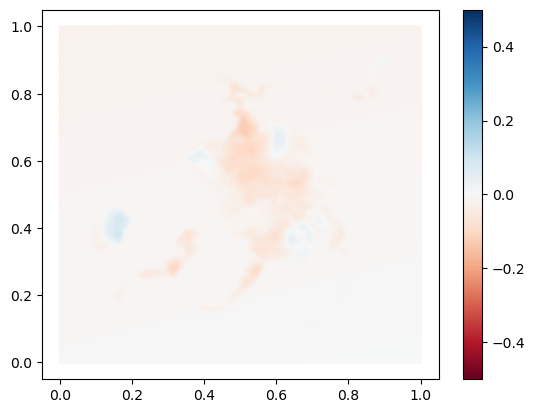

In [21]:
plt.scatter(x, y, c = prd[:, 1], s=0.4, vmax = 0.5, vmin = -0.5, cmap = "RdBu")
plt.colorbar();

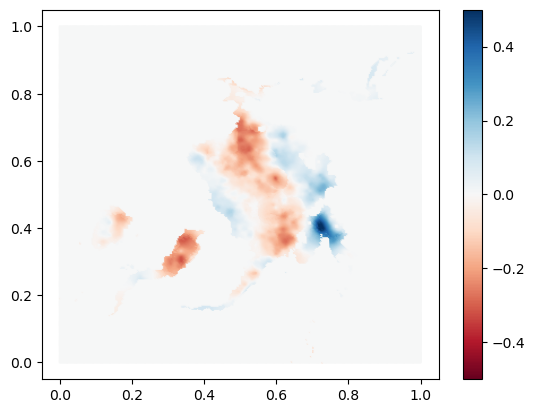

In [22]:
plt.scatter(x, y, c = obs[:, 1], s=0.4, vmax = 0.5, vmin = -0.5, cmap = "RdBu")
plt.colorbar();

In [ ]:


data_list = []
loader = DataLoader(data_list, batch_size=32)

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000019E2D42F1C0> (for post_execute):


In [138]:
G.nodes[(0,2)]

{'x': array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])}

ERROR! Session/line number was not unique in database. History logging moved to new session 183


In [108]:
G = nx.Graph()

# Add some cars (just do 4 for now)
G.add_nodes_from([
      (1, {'Brand': 'Ford'}),
      (2, {'Brand': 'Audi'}),
      (3, {'Brand': 'BMW'}),
      (4, {'Brand': 'Peugot'}),
      (5, {'Brand': 'Lexus'}),
])

# Add some edges
G.add_edges_from([
                  (1, 2), (1, 4), (1, 5),
                  (2, 3), (2, 4),
                  (3, 2), (3, 5), 
                  (4, 1), (4, 2),
                  (5, 1), (5, 3)
])

# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)
pyg_graph

Data(edge_index=[2, 12], Brand=[5], num_nodes=5)

In [83]:
G = nx.grid_2d_graph(20,20)
G.nodes

# Set all weights to 1
for edge in G.edges:
    G.edges[edge]['weight'] = 1

In [263]:
row, col = 6,6
G = nx.grid_2d_graph(row, col)

G.add_edges_from([
    ((x, y), (x+1, y+1))
    for x in range(row-1)
    for y in range(col-1)
] + [
    ((x+1, y), (x, y+1))
    for x in range(row-1)
    for y in range(col-1)
], weight=1.4)


In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=2), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

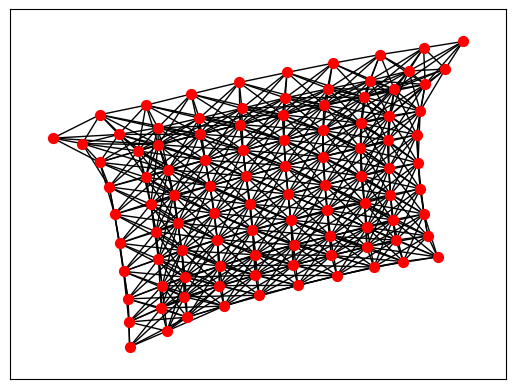

In [19]:
nx.draw_networkx(G, with_labels = False, node_size = 50, node_color = "red")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

N=4
np.random.seed(17) #For reproducibility
A=np.random.choice([200,400,800], size=(N,N))
A[3,1] = 1500
im=plt.imshow(A,origin="upper",interpolation="nearest",cmap=plt.cm.gray_r)
plt.colorbar(im)


G = nx.grid_2d_graph(N,N)

labels=dict(((i,j),i + (N-1-j)*N) for i, j in G.nodes())
nx.relabel_nodes(G,labels,False) #False=relabel the nodes in place
inds=labels.keys()
vals=labels.values()
inds=[(N-j-1,N-i-1) for i,j in inds]

#Create the dictionary of positions for the grid
grid_pos=dict(zip(vals,inds)) #Format: {node ID:(i,j)}


#Plot the graph with the size based on the values
plt.figure()
nx.draw(G,pos=grid_pos,with_labels=True,node_size=A.T.flatten())

plt.show()

In [87]:
from torch_geometric.datasets import LastFMAsia

graph = LastFMAsia("./data")
X = graph.data.x  # torch.Size([7624, 128])
edge_index = graph.data.edge_index  # torch.Size([2, 55612])
y = graph.data.y.squeeze()  # torch.Size([7624])

Processing...
Done!


In [93]:
graph.data.y

tensor([ 8, 17,  3,  ...,  0, 17, 11])

### Read sea ice drift data

In [20]:
year = 2019
model_name = f"torch_conv2d_lr0.002_wo{year}_nophy_gpu"

model = Net()
model.load_state_dict(torch.load(f'../model/{model_name}.pth'))
# model.eval()

<All keys matched successfully>

In [21]:
first = True
data_path = "D:\\PINN\\data"

years = np.array([])
months = np.array([])
days = np.array([])

with open(data_path + '/train_cnn_2019_2021.pkl', 'rb') as file:
    xx, yy, days, months, years, cnn_input, cnn_output = pickle.load(file)

cnn_input = np.transpose(cnn_input, (0, 3, 1, 2))
cnn_output = np.transpose(cnn_output, (0, 3, 1, 2))
    
for month in np.arange(1, 13):    
    
    mask1 = (months == month) & (years == year) # Test samples

    test_input = cnn_input[mask1, :, 41:, :-41]
    test_output = cnn_output[mask1, :, 41:, :-41]
    
    n_samples = np.shape(test_input)[0]

    print(f"######## TRAINING DATA IS PREPARED (# of samples: {n_samples}) ########")
    
    pred = model(torch.tensor(test_input, dtype=torch.float32)).detach().numpy()   

    prd_vel = np.sqrt(pred[:, 0, :, :]**2 + pred[:, 1, :, :]**2)
    obs_vel = np.sqrt(test_output[:, 0, :, :]**2 + test_output[:, 1, :, :]**2)

    pred = np.append(pred, np.expand_dims(prd_vel, axis = 1), axis = 1)
    test_output = np.concatenate((test_output, np.expand_dims(obs_vel, axis = 1)), axis = 1)

    n_samples, channels, row, col = np.shape(test_output)

    vmax = [10, 10, 100, 20]
    vmin = [-10, -10, 0, 0]
    scaling = [50, 50, 100, 50]
    offset = [0, 0, 0, 0]
    cm = ['Spectral', 'Spectral', 'Blues', 'Spectral']

    sic = test_output[:, 2, :, :] + test_input[:, 2, :, :]

    df = pd.DataFrame({})

    sic = (test_output[:, 2, :, :] + test_input[:, 2, :, :])
    fig, ax = plt.subplots(4, 4, figsize = (9,9))

    for c in range(0, channels):

        if c == 2:
            obs = ((test_output[:, c, :, :] + test_input[:, c, :, :]) + offset[c]) *scaling[c] 
            prd = ((pred[:, c, :, :] + test_input[:, c, :, :]) + offset[c]) *scaling[c]
        else:
            obs = ((test_output[:, c, :, :]) + offset[c]) *scaling[c] 
            prd = ((pred[:, c, :, :]) + offset[c]) *scaling[c] 

        prd[sic == 0] = np.nan
        obs[sic == 0] = np.nan        
        
        for i in range(0, n_samples):
            df.loc[i, "MAE{0}".format(c)] = MAE(prd[i], obs[i])
            df.loc[i, "R{0}".format(c)] = corr(prd[i], obs[i])

        ax[0, c].scatter(prd, obs,  s = 3, alpha = 0.002)
        ax[0, c].text(vmin[c] + (vmax[c]-vmin[c])*0.05, vmax[c] - (vmax[c]-vmin[c])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
        ax[0, c].set_xlim(vmin[c], vmax[c])
        ax[0, c].set_ylim(vmin[c], vmax[c])
        ax[0, c].plot([vmin[c], vmax[c]], [vmin[c], vmax[c]], ls = "--", color = "gray")

    #     ax[1, k].pcolormesh(xx, yy, prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    #     ax[2, k].pcolormesh(xx, yy, obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

        ax[1, c].imshow(np.nanmean(prd, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = cm[c])
        ax[2, c].imshow(np.nanmean(obs, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = cm[c])
        if c == 2:
            ax[3, c].imshow(np.nanmean(prd-obs, axis = 0), vmax = 50, vmin = -50, cmap = "RdBu")
        else:
            ax[3, c].imshow(np.nanmean(prd-obs, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = "RdBu")

    df.to_csv("../result/Result_{0}_{1}{2}.csv".format(model_name, year, str(month).zfill(2)))    

    plt.savefig("../result/Test_{0}_{1}{2}.png".format(model_name, year, str(month).zfill(2)), bbox_inches='tight')
    plt.close()

######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 28) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########


In [22]:
year = 2019
model_name = f"torch_conv2d_lr0.002_wo{year}_phy_gpu"

model = Net()
model.load_state_dict(torch.load(f'../model/{model_name}.pth'))
# model.eval()

<All keys matched successfully>

In [23]:
first = True
data_path = "D:\\PINN\\data"

years = np.array([])
months = np.array([])
days = np.array([])

with open(data_path + '/train_cnn_2019_2021.pkl', 'rb') as file:
    xx, yy, days, months, years, cnn_input, cnn_output = pickle.load(file)

cnn_input = np.transpose(cnn_input, (0, 3, 1, 2))
cnn_output = np.transpose(cnn_output, (0, 3, 1, 2))
    
for month in np.arange(1, 13):    
    
    mask1 = (months == month) & (years == year) # Test samples

    test_input = cnn_input[mask1, :, 41:, :-41]
    test_output = cnn_output[mask1, :, 41:, :-41]
    
    n_samples = np.shape(test_input)[0]

    print(f"######## TRAINING DATA IS PREPARED (# of samples: {n_samples}) ########")
    
    pred = model(torch.tensor(test_input, dtype=torch.float32)).detach().numpy()   

    prd_vel = np.sqrt(pred[:, 0, :, :]**2 + pred[:, 1, :, :]**2)
    obs_vel = np.sqrt(test_output[:, 0, :, :]**2 + test_output[:, 1, :, :]**2)

    pred = np.append(pred, np.expand_dims(prd_vel, axis = 1), axis = 1)
    test_output = np.concatenate((test_output, np.expand_dims(obs_vel, axis = 1)), axis = 1)

    n_samples, channels, row, col = np.shape(test_output)

    vmax = [10, 10, 100, 20]
    vmin = [-10, -10, 0, 0]
    scaling = [50, 50, 100, 50]
    offset = [0, 0, 0, 0]
    cm = ['Spectral', 'Spectral', 'Blues', 'Spectral']

    sic = test_output[:, 2, :, :] + test_input[:, 2, :, :]

    df = pd.DataFrame({})

    sic = (test_output[:, 2, :, :] + test_input[:, 2, :, :])
    fig, ax = plt.subplots(4, 4, figsize = (9,9))

    for c in range(0, channels):

        if c == 2:
            obs = ((test_output[:, c, :, :] + test_input[:, c, :, :]) + offset[c]) *scaling[c] 
            prd = ((pred[:, c, :, :] + test_input[:, c, :, :]) + offset[c]) *scaling[c]
        else:
            obs = ((test_output[:, c, :, :]) + offset[c]) *scaling[c] 
            prd = ((pred[:, c, :, :]) + offset[c]) *scaling[c] 

        prd[sic == 0] = np.nan
        obs[sic == 0] = np.nan        
        
        for i in range(0, n_samples):
            df.loc[i, "MAE{0}".format(c)] = MAE(prd[i], obs[i])
            df.loc[i, "R{0}".format(c)] = corr(prd[i], obs[i])

        ax[0, c].scatter(prd, obs,  s = 3, alpha = 0.002)
        ax[0, c].text(vmin[c] + (vmax[c]-vmin[c])*0.05, vmax[c] - (vmax[c]-vmin[c])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
        ax[0, c].set_xlim(vmin[c], vmax[c])
        ax[0, c].set_ylim(vmin[c], vmax[c])
        ax[0, c].plot([vmin[c], vmax[c]], [vmin[c], vmax[c]], ls = "--", color = "gray")

    #     ax[1, k].pcolormesh(xx, yy, prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    #     ax[2, k].pcolormesh(xx, yy, obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

        ax[1, c].imshow(np.nanmean(prd, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = cm[c])
        ax[2, c].imshow(np.nanmean(obs, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = cm[c])
        if c == 2:
            ax[3, c].imshow(np.nanmean(prd-obs, axis = 0), vmax = 50, vmin = -50, cmap = "RdBu")
        else:
            ax[3, c].imshow(np.nanmean(prd-obs, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = "RdBu")

    df.to_csv("../result/Result_{0}_{1}{2}.csv".format(model_name, year, str(month).zfill(2)))    

    plt.savefig("../result/Test_{0}_{1}{2}.png".format(model_name, year, str(month).zfill(2)), bbox_inches='tight')
    plt.close()

######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 28) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 31) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########
######## TRAINING DATA IS PREPARED (# of samples: 30) ########


## Unet

In [87]:
### Set up what month you want to test ===========================
year = 2019
### ==============================================================

n_layers = 10
n_filters = 32
activation = "linear"

model_name  = "unet_{0}_{1}_{2}_wo{3}_nophy".format(n_layers, n_filters, activation, str(year).zfill(2)) #, "conv2d_{0}_{1}_linear_wo{2}_phy".format(n_layers, n_filters, str(year).zfill(2))]:
seq = tf.keras.models.load_model("../model/{0}".format(model_name), compile = False)

######## TRAINING DATA IS PREPARED (# of samples: 31) ########
1/1 [==============================] - 3s 3s/step


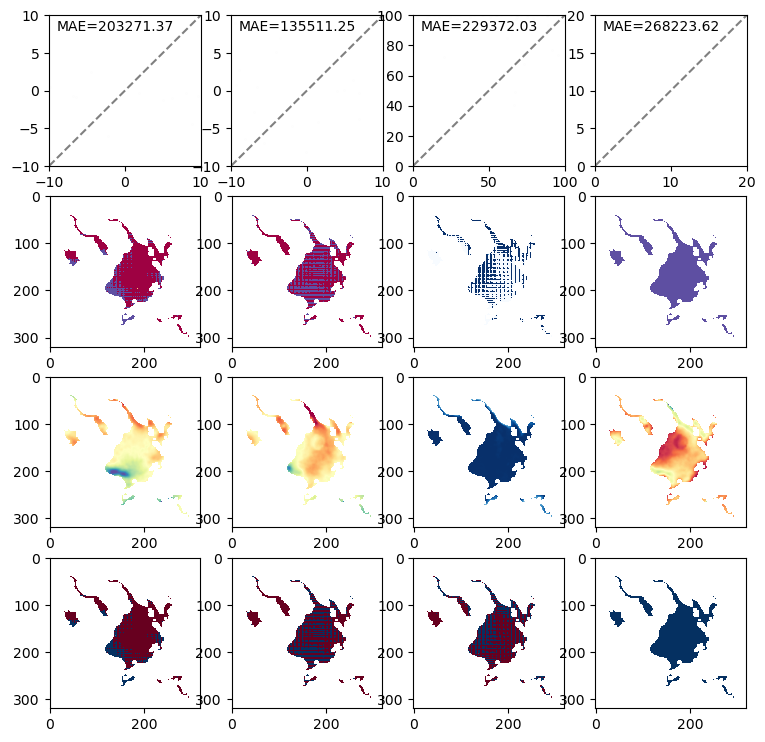

In [88]:
first = True
data_path = "D:\\PINN\\data"

years = np.array([])
months = np.array([])
days = np.array([])

for month in np.arange(1, 2):
    with open(data_path + '\\train_entire_{0}{1}.pkl'.format(year, str(month).zfill(2)), 'rb') as file:
        xx, yy, input0, output0 = pickle.load(file)
        output0[:, :, :, 2] = output0[:, :, :, 2] - input0[:, :, :, 2]

    n_samples = np.shape(output0)[0]

    cnn_input = input0
    cnn_output = output0

    days = np.concatenate((days, np.arange(0, n_samples) + 1))
    months = np.concatenate((months, np.ones(n_samples) * month))
    years = np.concatenate((years, np.ones(n_samples) * year))

    cnn_input, cnn_output = float_to_int(cnn_input, cnn_output)

    print("######## TRAINING DATA IS PREPARED (# of samples: {0}) ########".format(len(days)))
    test_input = cnn_input[:, 41:, :-41, :] / 20000
    test_output = cnn_output[:, 41:, :-41, :] / 20000

    pred = seq.predict(test_input)    

    prd_vel = np.sqrt(pred[:, :, :, 0]**2 + pred[:, :, :, 1]**2)
    obs_vel = np.sqrt(test_output[:, :, :, 0]**2 + test_output[:, :, :, 1]**2)

    pred = np.append(pred, np.expand_dims(prd_vel, axis = 3), axis = 3)
    test_output = np.concatenate((test_output, np.expand_dims(obs_vel, axis = 3)), axis = 3)

    n_samples, row, col, channels = np.shape(test_output)

    vmax = [10, 10, 100, 20]
    vmin = [-10, -10, 0, 0]
    scaling = [50, 50, 100, 50]
    offset = [0, 0, 0, 0]
    cm = ['Spectral', 'Spectral', 'Blues', 'Spectral']

    sic = test_output[:, :, :, 2] + test_input[:, :, :, 2]

    df = pd.DataFrame({})

    sic = (test_output[:, :, :, 2] + test_input[:, :, :, 2])
    fig, ax = plt.subplots(4, 4, figsize = (9,9))

    for c in range(0, channels):

        if c == 2:
            obs = ((test_output[:, :, :, c] + test_input[:, :, :, c]) + offset[c]) *scaling[c] 
            prd = ((pred[:, :, :, c] + test_input[:, :, :, c]) + offset[c]) *scaling[c] 
        else:
            obs = ((test_output[:, :, :, c]) + offset[c]) *scaling[c] 
            prd = ((pred[:, :, :, c]) + offset[c]) *scaling[c] 

        prd[sic == 0] = np.nan
        obs[sic == 0] = np.nan        
        
        for i in range(0, n_samples):
            df.loc[i, "MAE{0}".format(c)] = MAE(prd[i], obs[i])
            df.loc[i, "R{0}".format(c)] = corr(prd[i], obs[i])

        ax[0, c].scatter(prd, obs,  s = 3, alpha = 0.002)
        ax[0, c].text(vmin[c] + (vmax[c]-vmin[c])*0.05, vmax[c] - (vmax[c]-vmin[c])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
        ax[0, c].set_xlim(vmin[c], vmax[c])
        ax[0, c].set_ylim(vmin[c], vmax[c])
        ax[0, c].plot([vmin[c], vmax[c]], [vmin[c], vmax[c]], ls = "--", color = "gray")

    #     ax[1, k].pcolormesh(xx, yy, prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    #     ax[2, k].pcolormesh(xx, yy, obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

        ax[1, c].imshow(np.nanmean(prd, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = cm[c])
        ax[2, c].imshow(np.nanmean(obs, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = cm[c])
        if c == 2:
            ax[3, c].imshow(np.nanmean(prd-obs, axis = 0), vmax = 50, vmin = -50, cmap = "RdBu")
        else:
            ax[3, c].imshow(np.nanmean(prd-obs, axis = 0), vmax = vmax[c], vmin = vmin[c], cmap = "RdBu")

#     df.to_csv("../result/Result_{0}_{1}{2}.csv".format(model_name, year, str(month).zfill(2)))    

#     plt.savefig("../result/Test_{0}_{1}{2}.png".format(model_name, year, str(month).zfill(2)), bbox_inches='tight')
#     plt.close()

## Fitting curve

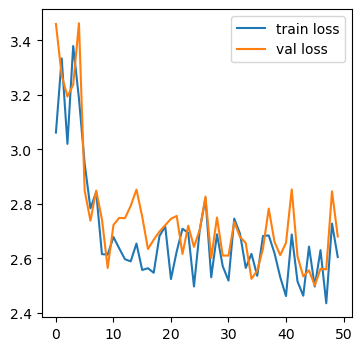

In [14]:
model_name = "torch_conv2d_lr0.002_wo2019_phy_gpu"
with open('../model/history_{0}.pkl'.format(model_name), 'rb') as file:
    history = pickle.load(file)

plt.subplots(1,1, figsize = (4,4))
plt.plot(history['loss'], label = "train loss")
plt.plot(history['val_loss'], label = "val loss")
plt.legend();
# plt.ylim(0.135, 0.15)
# df = pd.read_csv("../result/Result_{0}.csv".format(model_name))

# plt.plot(df['MAE0'], c = "r", ls = "--")
# plt.plot(df['MAE1'], c = "r", ls = "-")

# model_name = model_name.replace("phy", "nophy")

# df = pd.read_csv("../result/Result_{0}.csv".format(model_name))

# plt.plot(df['MAE0'], c = "b", ls = "--")
# plt.plot(df['MAE1'], c = "b", ls = "-")

plt.savefig("../result/Curve_{0}.png".format(model_name), bbox_inches='tight')
# plt.close()

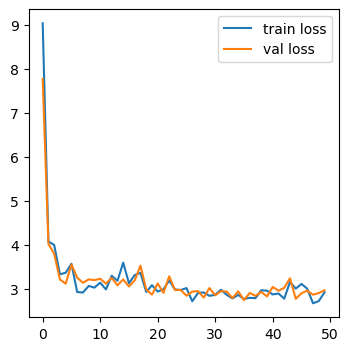

In [13]:
model_name = "torch_conv2d_lr0.005_wo2019_phy_gpu"
with open('../model/history_{0}.pkl'.format(model_name), 'rb') as file:
    history = pickle.load(file)

plt.subplots(1,1, figsize = (4,4))
plt.plot(history['loss'], label = "train loss")
plt.plot(history['val_loss'], label = "val loss")
plt.legend();
# plt.ylim(0.135, 0.15)
# df = pd.read_csv("../result/Result_{0}.csv".format(model_name))

# plt.plot(df['MAE0'], c = "r", ls = "--")
# plt.plot(df['MAE1'], c = "r", ls = "-")

# model_name = model_name.replace("phy", "nophy")

# df = pd.read_csv("../result/Result_{0}.csv".format(model_name))

# plt.plot(df['MAE0'], c = "b", ls = "--")
# plt.plot(df['MAE1'], c = "b", ls = "-")

plt.savefig("../result/Curve_{0}.png".format(model_name), bbox_inches='tight')
# plt.close()

## Error plot

In [24]:
n_layers = 8
n_filters = 16
activation = "linear"

model_name  = f"torch_conv2d_lr0.002_wo{year}_nophy_gpu"
files = glob.glob("../result/Result_{0}*.csv".format(model_name))

first = True

for f in files:
    df0 = pd.read_csv(f, index_col = 0)
    df0['month'] = f[-6:-4]
    df0['day'] = df0.index + 1
    df0 = df0.dropna()
    
    if first:
        df_np = df0
        first = False
    else:
        df_np = pd.concat([df_np, df0]).reset_index(drop = True)
        
n_layers = 8
n_filters = 32
activation = "linear"
        
model_name  = model_name = f"torch_conv2d_lr0.002_wo{year}_phy_gpu"
files = glob.glob("../result/Result_{0}*.csv".format(model_name))

first = True

for f in files:
    df0 = pd.read_csv(f, index_col = 0)
    df0['month'] = f[-6:-4]
    df0['day'] = df0.index + 1
    df0 = df0.dropna()
    
    if first:
        df_p = df0
        first = False
    else:
        df_p = pd.concat([df_p, df0]).reset_index(drop = True)


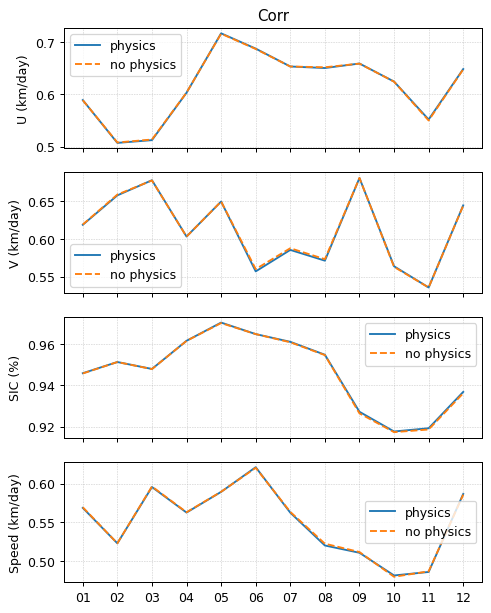

In [25]:
mdf_p = df_p.groupby(by = "month").mean()
mdf_np = df_np.groupby(by = "month").mean()

ylab = ["U (km/day)", "V (km/day)", "SIC (%)", "Speed (km/day)"]
fig, ax = plt.subplots(4,1, figsize = (6,8), dpi = 90, sharex = True)
ax[0].set_title("Corr")
for k in range(0, len(ax)):
    ax[k].plot(mdf_p['R{0}'.format(k)], label = "physics")
    ax[k].plot(mdf_np['R{0}'.format(k)], ls = "--", label = "no physics")
    ax[k].set_ylabel(ylab[k])
    ax[k].grid(ls = ":", lw = 0.5)
    ax[k].legend()

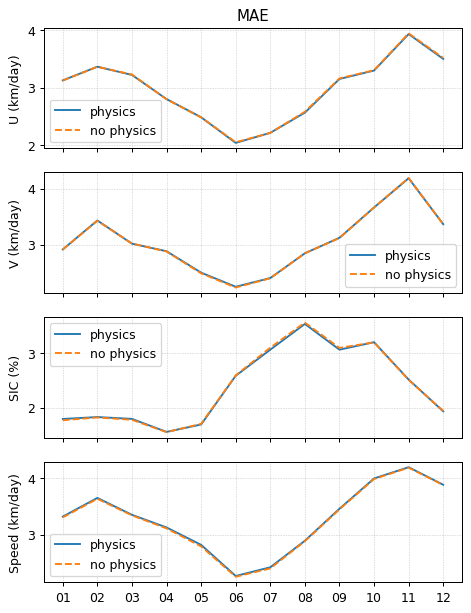

In [26]:
mdf_p = df_p.groupby(by = "month").mean()
mdf_np = df_np.groupby(by = "month").mean()

ylab = ["U (km/day)", "V (km/day)", "SIC (%)", "Speed (km/day)"]
fig, ax = plt.subplots(4,1, figsize = (6,8), dpi = 90, sharex = True)
ax[0].set_title("MAE")
for k in range(0, len(ax)):
    ax[k].plot(mdf_p['MAE{0}'.format(k)], label = "physics")
    ax[k].plot(mdf_np['MAE{0}'.format(k)], ls = "--", label = "no physics")
    ax[k].set_ylabel(ylab[k])
    ax[k].grid(ls = ":", lw = 0.5)
    ax[k].legend()

In [29]:
n_layers = 8
n_filters = 16
activation = "linear"

model_name  = "conv2d_{0}_{1}_{2}_wo{3}_nophy".format(n_layers, n_filters, activation, str(year).zfill(2))
files = glob.glob("../result/Result_{0}*.csv".format(model_name))

first = True

for f in files:
    df0 = pd.read_csv(f, index_col = 0)
    df0['month'] = f[-6:-4]
    df0['day'] = df0.index + 1
    df0 = df0.dropna()
    
    if first:
        df_np = df0
        first = False
    else:
        df_np = pd.concat([df_np, df0]).reset_index(drop = True)
        
n_layers = 8
n_filters = 32
activation = "linear"
        
model_name  = "conv2d_{0}_{1}_{2}_wo{3}_phy".format(n_layers, n_filters, activation, str(year).zfill(2))
files = glob.glob("../result/Result_{0}*.csv".format(model_name))

first = True

for f in files:
    df0 = pd.read_csv(f, index_col = 0)
    df0['month'] = f[-6:-4]
    df0['day'] = df0.index + 1
    df0 = df0.dropna()
    
    if first:
        df_p = df0
        first = False
    else:
        df_p = pd.concat([df_p, df0]).reset_index(drop = True)


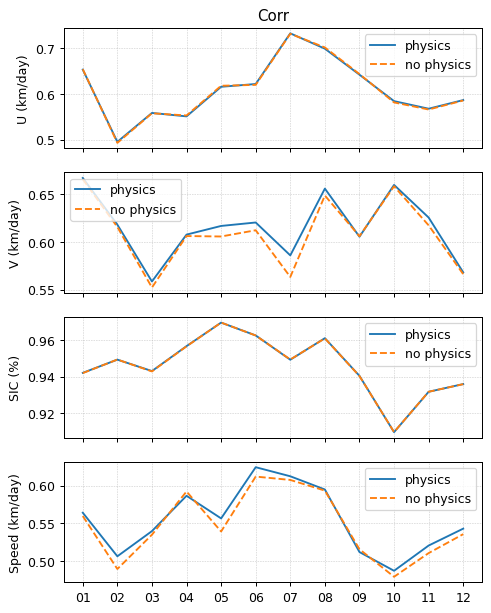

In [30]:
mdf_p = df_p.groupby(by = "month").mean()
mdf_np = df_np.groupby(by = "month").mean()

ylab = ["U (km/day)", "V (km/day)", "SIC (%)", "Speed (km/day)"]
fig, ax = plt.subplots(4,1, figsize = (6,8), dpi = 90, sharex = True)
ax[0].set_title("Corr")
for k in range(0, len(ax)):
    ax[k].plot(mdf_p['R{0}'.format(k)], label = "physics")
    ax[k].plot(mdf_np['R{0}'.format(k)], ls = "--", label = "no physics")
    ax[k].set_ylabel(ylab[k])
    ax[k].grid(ls = ":", lw = 0.5)
    ax[k].legend()

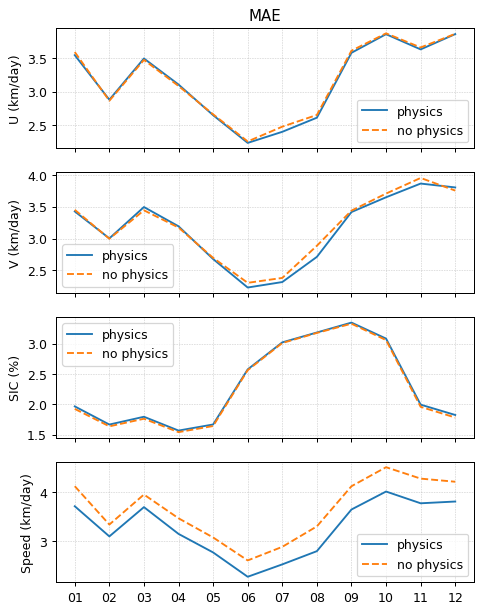

In [23]:
mdf_p = df_p.groupby(by = "month").mean()
mdf_np = df_np.groupby(by = "month").mean()

ylab = ["U (km/day)", "V (km/day)", "SIC (%)", "Speed (km/day)"]
fig, ax = plt.subplots(4,1, figsize = (6,8), dpi = 90, sharex = True)
ax[0].set_title("MAE")
for k in range(0, len(ax)):
    ax[k].plot(mdf_p['MAE{0}'.format(k)], label = "physics")
    ax[k].plot(mdf_np['MAE{0}'.format(k)], ls = "--", label = "no physics")
    ax[k].set_ylabel(ylab[k])
    ax[k].grid(ls = ":", lw = 0.5)
    ax[k].legend()

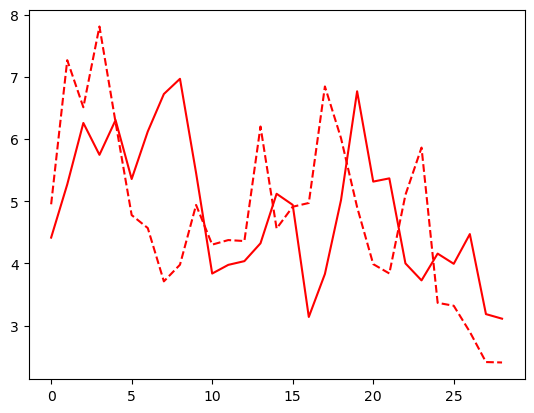

In [30]:
plt.plot(df['MAE0'], c = "r", ls = "--")
plt.plot(df['MAE1'], c = "r", ls = "-")

In [23]:
str(2020).zfill(2)

'2020'

In [ ]:
with open('../data/train_entire_2021{0}.pkl'.format(str(date).zfill(2)), 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)
    test_output[:, :, :, 2] = test_output[:, :, :, 2] - test_input[:, :, :, 2]

n_layers = 8
n_filters = 16

for model_name in ["conv2d_10_32_linear_wo{0}_phy".format(str(date).zfill(2)), "conv2d_10_32_linear_wo{0}_nophy".format(str(date).zfill(2))]:
    seq = tf.keras.models.load_model("../model/{0}".format(model_name), compile = False)

    pred = seq.predict(test_input)

    # Cell type visualization -------------------------------
    for ind in range(0, 25, 15):

        fig, ax = plt.subplots(4, 3, figsize = (7,9))

        vmax = [10, 10, 100]
        vmin = [-10, -10, 0]
        scaling = [50, 50, 100]
        offset = [-0.5, -0.5, 0]
        cm = ['Spectral', 'Spectral', 'Blues']

        sic = test_output[ind, :, :, 2] + test_input[ind, :, :, 2]

        for k in range(0, 3):
            if k == 2:
                obs = ((test_output[ind, :, :, k] + test_input[ind, :, :, 2]) + offset[k]) *scaling[k] 
                prd = ((pred[ind, :, :, k] + test_input[ind, :, :, 2]) + offset[k]) *scaling[k] 
            else:
                obs = ((test_output[ind, :, :, k]) + offset[k]) *scaling[k] 
                prd = ((pred[ind, :, :, k]) + offset[k]) *scaling[k] 

            prd[sic == 0] = np.nan
            obs[sic == 0] = np.nan

            ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
            ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
            ax[0, k].set_xlim(vmin[k], vmax[k])
            ax[0, k].set_ylim(vmin[k], vmax[k])
            ax[0, k].plot([vmin[k], vmax[k]], [vmin[k], vmax[k]], ls = "--", color = "gray")

        #     ax[1, k].pcolormesh(xx, yy, prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
        #     ax[2, k].pcolormesh(xx, yy, obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

            ax[1, k].imshow(prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
            ax[2, k].imshow(obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
            if k == 2:
                ax[3, k].imshow(prd-obs, vmax = 50, vmin = -50, cmap = "RdBu")
            else:
                ax[3, k].imshow(prd-obs, vmax = vmax[k], vmin = vmin[k], cmap = "RdBu")

        plt.savefig("../result/Test_{0}_{1}_{2}.png".format(str(date).zfill(2), model_name, ind), bbox_inches='tight')
        plt.close()

In [5]:
## TEST

Epoch 1/50
1/1 [==============================] - 0s 340ms/step - loss: 3409.9312
Epoch 2/50
1/1 [==============================] - 0s 13ms/step - loss: 57453440.0000
Epoch 3/50
1/1 [==============================] - 0s 11ms/step - loss: 971211931648.0000
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 16417689656360960.0000
Epoch 5/50
1/1 [==============================] - 0s 12ms/step - loss: 277530069727684067328.0000
Epoch 6/50
1/1 [==============================] - 0s 17ms/step - loss: 4691460692556401770233856.0000
Epoch 7/50
1/1 [==============================] - 0s 15ms/step - loss: 79306006003367960825246515200.0000
Epoch 8/50
1/1 [==============================] - 0s 18ms/step - loss: 1340615250371224446916860674310144.0000
Epoch 9/50
1/1 [==============================] - 0s 15ms/step - loss: inf
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: inf
Epoch 11/50
1/1 [==============================] - 0s 22ms/step - loss: inf
Epoch 1

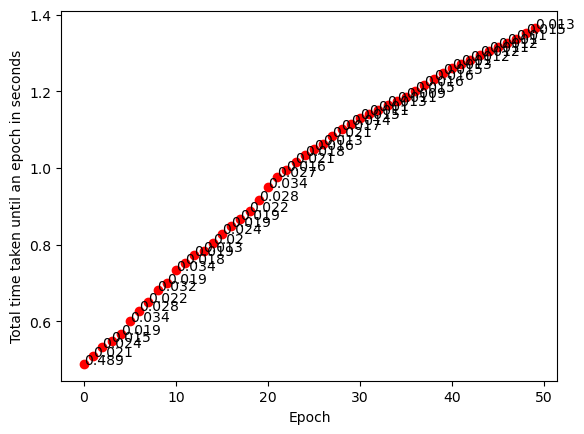

In [15]:
from datetime import datetime

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append(tf.timestamp() - self.timetaken)
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(self.epochs, self.times, 'ro')
        for i in range(len(self.epochs)):
            j = self.times[i].numpy()
            if i == 0:
                plt.text(i, j, str(round(j, 3)))
            else:
                j_prev = self.times[i-1].numpy()
                plt.text(i, j, str(round(j-j_prev, 3)))
            plt.savefig(datetime.now().strftime("%Y%m%d%H%M%S") + ".png")

model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=50, verbose=1, callbacks = [timecallback()])
print(history.params)

# check the keys of history object
print(history.history.keys())

In [19]:
history